<a href="https://colab.research.google.com/github/ericmassip/in_the_name_of_deep_learning/blob/master/autoencoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

!pip install livelossplot
from livelossplot import PlotLossesKeras

In [0]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "drive/My Drive/CV/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
image_size = 128
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_gray_128.p', mode='rb'))
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_gray_64.p', mode='rb'))
x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_rgb_128.p', mode='rb'))
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_rgb_64.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_gray_128.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_gray_64.p', mode='rb'))
x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_rgb_128.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_rgb_64.p', mode='rb'))
y_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/y_train.p', mode='rb'))
y_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/y_val.p', mode='rb'))
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(657, 128, 128, 3)
(644, 128, 128, 3)
(657, 3)
(644, 3)


# Auto-Encoder with 8192 coding variables

In [0]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Flatten,Dense
from keras.models import Model

batch_size = 32
epochs = 60
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
  
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    
    #flat1 = Flatten()(conv4)
    #dense1 = Dense(512, activation='relu')(flat1)
    #resh2 = Reshape((8,8,8))(dense1)

    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded
  
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.summary()

from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='8192_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 64)        0         
__________

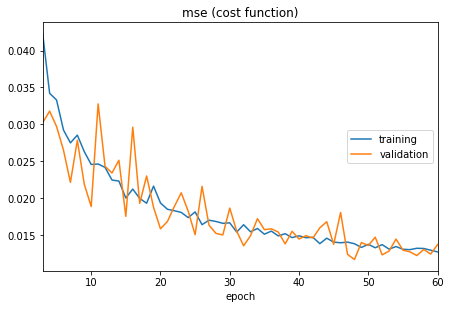

mse (cost function):
training   (min:    0.013, max:    0.084, cur:    0.013)
validation (min:    0.012, max:    0.069, cur:    0.014)


In [0]:
autoencoder.compile(loss='mse',
                    optimizer = 'rmsprop')

autoencoder_train = autoencoder.fit(x_train, 
                                    x_train, 
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, x_val),
                                    callbacks=[PlotLossesKeras(), 
                                               ModelCheckpoint(filepath=path+'autoencoder_rgb_8192_' + str(image_size) + '.h5', monitor='val_loss', save_best_only=True)])

In [0]:
output_8192 = autoencoder.predict(x_val)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
reconstr_mse = mean_squared_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_8192.flatten().reshape((output_8192.shape[0],-1)))
reconstr_mae = mean_absolute_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_8192.flatten().reshape((output_8192.shape[0],-1)))
print('MSE reconstruction error = %.2f' % reconstr_mse)
print('MAE reconstruction error = %.2f' % reconstr_mae)

MSE reconstruction error = 0.01
MAE reconstruction error = 0.08


# Auto-Encoder with 4096 coding variables

In [0]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Flatten,Dense
from keras.models import Model

batch_size = 32
epochs = 60
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
  
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4)
    
    #flat1 = Flatten()(conv4)
    #dense1 = Dense(512, activation='relu')(flat1)
    #resh2 = Reshape((8,8,8))(dense1)

    #decoder
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv8) 
    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3) 
    up4 = UpSampling2D((2,2))(conv9)
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up4)
    return decoded
  
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.summary()

from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='4096_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 64)        0         
__________

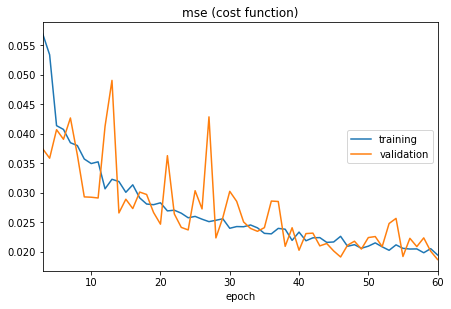

mse (cost function):
training   (min:    0.019, max:    0.084, cur:    0.019)
validation (min:    0.019, max:    0.072, cur:    0.019)


In [0]:
autoencoder.compile(loss='mse',
                    optimizer = 'rmsprop')

autoencoder_train = autoencoder.fit(x_train, 
                                    x_train, 
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, x_val),
                                    callbacks=[PlotLossesKeras(), 
                                               ModelCheckpoint(filepath=path+'autoencoder_rgb_4096_' + str(image_size) + '.h5', monitor='val_loss', save_best_only=True)])

## Results

In [0]:
output_4096 = autoencoder.predict(x_val)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
reconstr_mse = mean_squared_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_4096.flatten().reshape((output_4096.shape[0],-1)))
reconstr_mae = mean_absolute_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_4096.flatten().reshape((output_4096.shape[0],-1)))
print('MSE reconstruction error = %.2f' % reconstr_mse)
print('MAE reconstruction error = %.2f' % reconstr_mae)

MSE reconstruction error = 0.02
MAE reconstruction error = 0.10


# Auto-Encoder with 2048 coding variables

In [0]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Flatten,Dense
from keras.models import Model

batch_size = 32
epochs = 60
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
  
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool5)
    
    #flat1 = Flatten()(conv4)
    #dense1 = Dense(512, activation='relu')(flat1)
    #resh2 = Reshape((8,8,8))(dense1)

    #decoder
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6) 
    up1 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv9)
    conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up4 = UpSampling2D((2,2))(conv10)
    conv11 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up5 = UpSampling2D((2,2))(conv11)
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up5)
    return decoded
  
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.summary()

from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='2048_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 64)        0         
__________

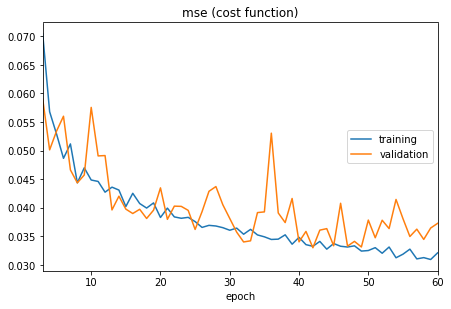

mse (cost function):
training   (min:    0.031, max:    0.078, cur:    0.032)
validation (min:    0.033, max:    0.074, cur:    0.037)


In [0]:
autoencoder.compile(loss='mse',
                    optimizer = 'rmsprop')

autoencoder_train = autoencoder.fit(x_train, 
                                    x_train, 
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, x_val),
                                    callbacks=[PlotLossesKeras(), 
                                               ModelCheckpoint(filepath=path+'autoencoder_rgb_2048_' + str(image_size) + '.h5', monitor='val_loss', save_best_only=True)])

## Results

In [0]:
output_2048 = autoencoder.predict(x_val)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
reconstr_mse = mean_squared_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_2048.flatten().reshape((output_2048.shape[0],-1)))
reconstr_mae = mean_absolute_error(x_val.flatten().reshape((x_val.shape[0],-1)),output_2048.flatten().reshape((output_2048.shape[0],-1)))
print('MSE reconstruction error = %.2f' % reconstr_mse)
print('MAE reconstruction error = %.2f' % reconstr_mae)

MSE reconstruction error = 0.04
MAE reconstruction error = 0.15


## Comparison

In [0]:
def plot_comparison(k):
  plt.subplot(141)
  plt.title('2048 Output')
  plt.imshow(output_2048[k,:,:,:])
  plt.axis('off')
  plt.subplot(142)
  plt.title('4096 Output')
  plt.imshow(output_4096[k,:,:,:])
  plt.axis('off')
  plt.subplot(143)
  plt.title('8192 Output')
  plt.imshow(output_8192[k,:,:,:])
  plt.axis('off')
  plt.subplot(144)
  plt.title('Original')
  plt.imshow(x_val[k,:,:,:])
  plt.axis('off')
  plt.show()

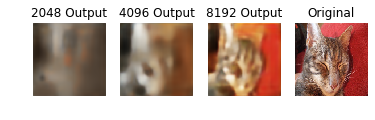

In [0]:
k = 0
plot_comparison(k)

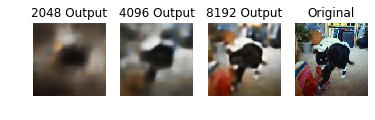

In [0]:
k = 20
plot_comparison(k)

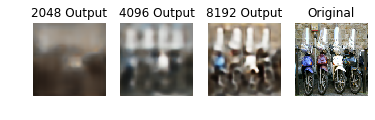

In [0]:
k = 300
plot_comparison(k)

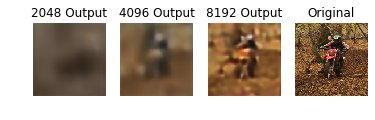

In [0]:
k = 400
plot_comparison(k)

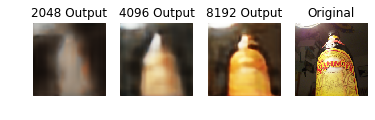

In [0]:
k = 550
plot_comparison(k)

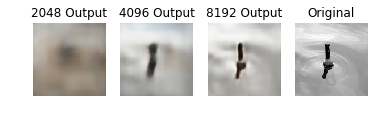

In [0]:
k = 600
plot_comparison(k)

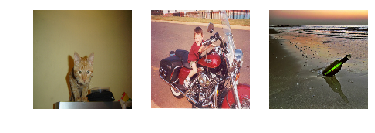

In [0]:
plt.subplot(131)
plt.imshow(x_train[100,:,:,:])
plt.axis('off')
plt.subplot(132)
plt.imshow(x_train[360,:,:,:])
plt.axis('off')
plt.subplot(133)
plt.imshow(x_train[630,:,:,:])
plt.axis('off')
plt.show()